# Cognitive Algorithms - Assignment 2 
Cognitive Algorithms        
Winter Term 2020/21      
Technische Universität Berlin     
Fachgebiet Maschinelles Lernen 

**Respective quiz due on Nov 24, 2020 23:59 via ISIS**

**Answer the questions on Isis in 'Assignment 2 - Quiz' and copy code from this notebook where necessary.**

---

# Programming

*Please keep in mind, that we will deduct one point for each unnecessary loop.*     

In this assignment you will compare the three linear classification algorithms that you encountered in the lecture - the Perceptron, the Nearest Centroid Classifier (NCC) and the Linear Discriminant Analysis (LDA). This comparision is done on a toy data set.
Your task will be to implement LDA and use the provided code to compare the algorithms.
  
*Below you can find the provided code. Change the code only where indicated.*

---

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

plt.style.use('ggplot')

---
## Classifiers

### Task 1 - Implement LDA
Implement a linear discriminant analysis (LDA) classifer by completing the function stub ```train_lda```.
Remember how the weight $\textbf{w}$ and the bias $\beta$ are calculated for given class means $\textbf{w}_o,\textbf{w}_\Delta \in \mathbb{R}^d$ in comparison to the NCC
\begin{align}
    \textbf{w} &= \Sigma_X^{-1}(\textbf{w}_o - \textbf{w}_\Delta) \\
    \beta &= \textbf{w}^T \left(\frac{\textbf{w}_o + \textbf{w}_\Delta}{2}\right)
        + \log\left( \frac{n_\Delta}{n_o} \right).
\end{align}

In [3]:
def train_lda(X, Y):
    ''' Trains a linear discriminant analysis
    Definition:  w, b   = train_lda(X,Y)
    Input:       X       -  DxN array of N data points with D features
                 Y       -  1D array of length N of class labels {-1, 1}
    Output:      w       -  1D array of length D, weight vector
                 b       -  bias term for linear classification
    '''

    # hint: to calculate the covariance use np.cov(...)
    # hint: to invert a matrix you should youse np.linalg.pinv(...)
    #       instead of np.linalg.inv(...) - Why?
    """
    https://stackoverflow.com/questions/49357417/why-is-numpy-linalg-pinv-preferred-over-numpy-linalg-inv-for-creating-invers
    "If the determinant of the matrix is zero it will not have an inverse 
     and your inv function will not work.
     
     This usually happens if your matrix is singular.
     
     But pinv will. This is because pinv returns the inverse of your matrix when it is available
     and the pseudo inverse when it isn't.
     
     The different results of the functions are because of rounding errors in floating point arithmetic."
    """

    # your code here
    X_pos = X[:, Y>0]                                               # data points of class +1
    X_neg = X[:, Y<0]                                               # data points of class -1
    mu_pos = np.mean(X_pos, axis=1)                                 # class means (+1)
    mu_neg = np.mean(X_neg, axis=1)                                 # class means (-1)
    S_w = 1/2*np.cov(X_pos,bias=True) + 1/2*np.cov(X_neg,bias=True) # covarinace
    w = np.dot(np.linalg.pinv(S_w),(mu_pos-mu_neg))
    b = 1/2 * np.dot(w,(mu_pos+mu_neg)) + np.log(len(X_neg[0])/len(X_pos[0]))
    return w, b

In [4]:
def train_perceptron(X,Y,iterations=200,eta=.1):
    ''' Trains a linear perceptron
    Definition:  w, b, acc  = train_perceptron(X,Y,iterations=200,eta=.1)
    Input:       X       -  DxN array of N data points with D features
                 Y       -  1D array of length N of class labels {-1, 1}
                 iter    -  optional, number of iterations, default 200
                 eta     -  optional, learning rate, default 0.1
    Output:      w       -  1D array of length D, weight vector 
                 b       -  bias term for linear classification                          
    '''
    #include the bias term by adding a row of ones to X 
    X = np.concatenate((np.ones((1,X.shape[1])), X))
    #initialize weight vector
    weights = np.ones((X.shape[0]))/X.shape[0]
    for it in np.arange(iterations):
        # indices of misclassified data
        wrong = (np.sign(weights.dot(X)) != Y).nonzero()[0]
        if wrong.shape[0] > 0:
            # pick a random misclassified data point
            m = wrong[np.random.randint(0, wrong.shape[0])]
            #update weight vector (use variable learning rate (eta/(1.+it)) )
            weights = weights  + (eta/(1.+it)) * X[:, m] * Y[m]; 
            # compute accuracy
            wrong = (np.sign(weights.dot(X)) != Y).nonzero()[0]
    b = -weights[0] 
    w = weights[1:]
    return w,b

In [5]:
def train_ncc(X,Y):
    ''' Trains a nearest centroid classifier
    Definition:  w, b = train_ncc(X,Y)
    Input:       X       -  DxN array of N data points with D features
                 Y       -  1D array of length N of class labels {-1, 1}
    Output:      w       -  1D array of length D, weight vector  
                 b       -  bias term for linear classification                          
    '''
    #class means
    mupos = np.mean(X[:, Y>0], axis=1)
    muneg = np.mean(X[:, Y<0], axis=1)
    
    #weight vector and bias term
    w = mupos - muneg
    w /= np.linalg.norm(w)
    b = (w.dot(mupos) + w.dot(muneg)) / 2.
    return w, b

---

## Comparison of the classifiers

In the following we provide functions to load or generate data and visualize it.

In [6]:
def generate_gaussian(N=1000, mean=None, cov=None):
    ''' Gernerate data from multivariate normal distribution
    Definition: X = generate_gaussian(N=1000)
    Input:      N - number of samples
    Output:     X - DxN array with N d-dimensional data points
    '''
    if cov is None:
        cov = np.array([[3., 1.], [1., 1.5]])
    if mean is None:
        mean = np.array([-2., 0.5])
    return np.random.multivariate_normal(mean, cov, N).T

In [7]:
def acc(out, y):
    ''' Calculate the accuracy '''
    return 50 * (np.mean(out[y > 0] > 0) + np.mean(out[y < 0] < 0))

In [8]:
def prepare_plot(func, X, Y):
    ''' visualize a binary classifier function and return training accuracy '''
    
    mean_tar = np.mean(X[:, Y>0], axis=1)
    mean_non = np.mean(X[:, Y<0], axis=1)
    
    w, b = func(X, Y)
    
    # plot data points
    kwargs = {'s': 16, 'alpha': 0.5}
    plt.scatter(X[0, Y>0], X[1, Y>0], label='class $o$', **kwargs)
    plt.scatter(X[0, Y<0], X[1, Y<0], label='class $\Delta$', **kwargs)

    kwargs = {'s': 30, 'color': 'black'}
    plt.scatter([mean_tar[0], mean_non[0]], [mean_tar[1], mean_non[1]], **kwargs)

    # calculate decision boundary
    R = np.array([[0, -1], [1, 0]])
    w_orth = R.dot(w)
    m = w_orth[1] / w_orth[0]
    n = b / w[1]
    t = np.linspace(-10, 10, 100)
    y_t = m * t + n
    
    # plot boundary
    plt.plot(t, y_t, 'y', label='decision boundary')
    
    # plot axis settings
    plt.xlim(-7, 7)
    plt.ylim(-7, 7)
    
    # plot labeling
    plt.xlabel("x-axis")
    plt.ylabel("y-axis")
    plt.legend(loc='upper left')
    
    return acc(w.T.dot(X)-b, Y)

In [9]:
def compare_classifiers():
    '''For testing purposes'''
    
    # number of samples for test and training purposes
    Ntr = 1000
    
    # prepare data
    mean_tar = np.array([-1., .5])
    mean_non = np.array([2., -1.])
    
    np.random.seed(280220)
    X_tar = generate_gaussian(N=Ntr, mean=mean_tar)
    X_non = generate_gaussian(N=Ntr, mean=mean_non)
    np.random.seed()
    y_tar = np.ones(X_tar.shape[1])
    y_non = -np.ones(X_non.shape[1])
    
    X = np.concatenate((X_tar, X_non), axis=1)
    Y = np.concatenate((y_tar, y_non))
    
    plt.figure(figsize=(6, 18))

    plt.subplot(3, 1, 1)
    plt.title(f"Perceptron - accuracy={round(prepare_plot(train_perceptron, X, Y))}%")
    
    plt.subplot(3, 1, 2)
    plt.title(f"NCC - accuracy={round(prepare_plot(train_ncc, X, Y))}%")

    plt.subplot(3, 1, 3)
    plt.title(f"LDA - accuracy={round(prepare_plot(train_lda, X, Y))}%")
    
    plt.show()

### Task 2 - Run compare_classifiers

Test your LDA implementation with the provided function ```compare_classifiers```. It generates a 2D toy data set and plots the resulting separating hyperplanes for the three linear classification methods.

You can execute the cell with Ctrl+Return serveral times several times in a row.<br>
Keep track of the classification boundaries. How do they change in every iteration?

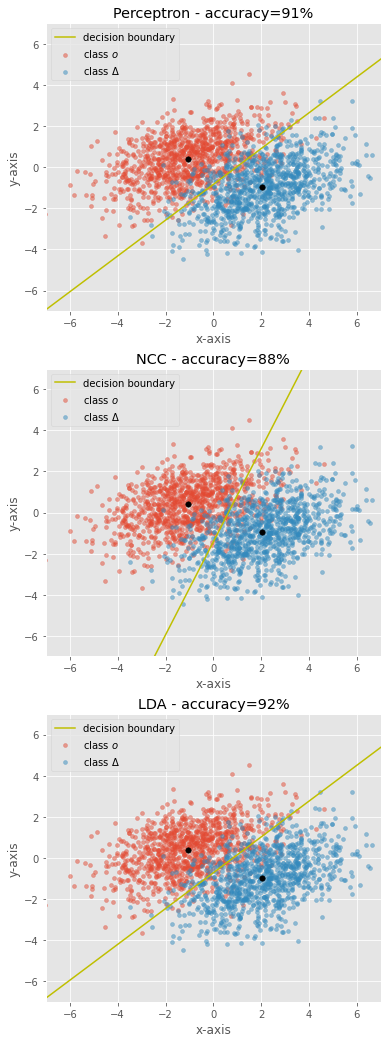

In [10]:
compare_classifiers()

### Task 3 - Modify LDA (optional)
Remove the log term of your LDA function and compare it with the previous output.

In [11]:
def train_lda_without_log(X, Y):
    ''' Trains a linear discriminant analysis
    Definition:  w, b   = train_lda(X,Y)
    Input:       X       -  DxN array of N data points with D features
                 Y       -  1D array of length N of class labels {-1, 1}
    Output:      w       -  1D array of length D, weight vector
                 b       -  bias term for linear classification
    '''

    # hint: to calculate the covariance use np.cov(...)
    # hint: to invert a matrix you should youse np.linalg.pinv(...)
    #       instead of np.linalg.inv(...) - Why?

    # your code here
    # class means
    X_pos = X[:, Y>0]
    X_neg = X[:, Y<0]
    mu_pos = np.mean(X_pos, axis=1)
    mu_neg = np.mean(X_neg, axis=1)
    # covarinace
    S_w = np.cov(X)
    w = np.dot(np.linalg.pinv(S_w),(mu_pos-mu_neg))
    b = np.dot(w,(mu_pos+mu_neg)/2) # + np.log(len(X_neg)/len(X_pos))   
    return w, b

In [12]:
def compare_classifiers_2():
    '''For testing purposes'''
    
    # number of samples for test and training purposes
    Ntr = 1000
    
    # prepare data
    mean_tar = np.array([-1., .5])
    mean_non = np.array([2., -1.])
    
    np.random.seed(280220)
    X_tar = generate_gaussian(N=Ntr, mean=mean_tar)
    X_non = generate_gaussian(N=Ntr, mean=mean_non)
    np.random.seed()
    y_tar = np.ones(X_tar.shape[1])
    y_non = -np.ones(X_non.shape[1])
    
    X = np.concatenate((X_tar, X_non), axis=1)
    Y = np.concatenate((y_tar, y_non))
    
    plt.figure(figsize=(6, 24))

    plt.subplot(4, 1, 1)
    plt.title(f"Perceptron - accuracy={round(prepare_plot(train_perceptron, X, Y))}%")
    
    plt.subplot(4, 1, 2)
    plt.title(f"NCC - accuracy={round(prepare_plot(train_ncc, X, Y))}%")

    plt.subplot(4, 1, 3)
    plt.title(f"LDA - accuracy={round(prepare_plot(train_lda, X, Y))}%")

    plt.subplot(4, 1, 4)
    plt.title(f"LDA - accuracy={round(prepare_plot(train_lda_without_log, X, Y))}%")

    plt.show()

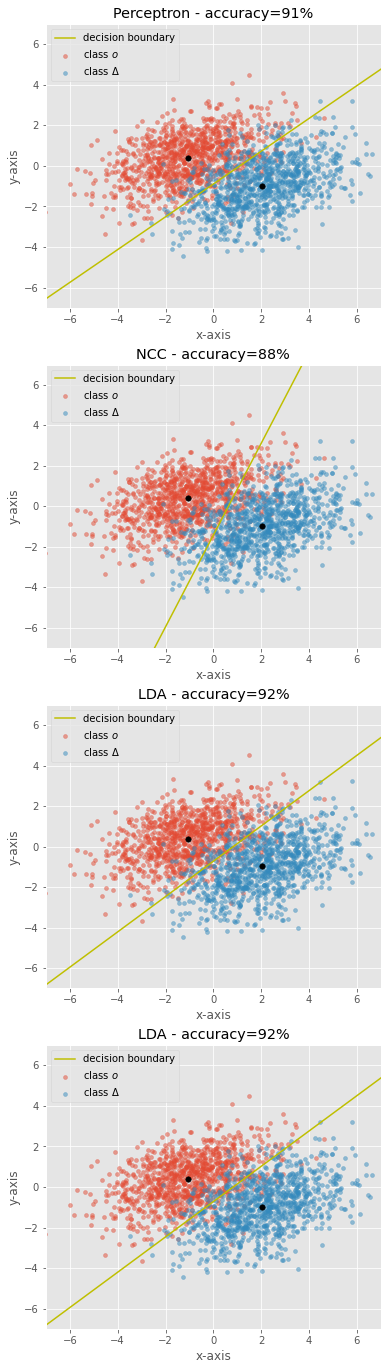

In [13]:
compare_classifiers_2()

**LDA without log term is the same, beacouse of the same dimenson of X_pos and X_neg --> log(n_neg/n_pos) = log(1) = 0**